In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, r2_score
import logging
logging.getLogger('NP').setLevel(logging.WARNING)


# --- Load and preprocess data ---
file_path = '/Users/rasmusmonsted/Desktop/Advanced BA/precipitation_imputed_data.parquet'
df = pd.read_parquet(file_path)
df = df.clip(lower=0, upper=60)

station = '05089'

/Users/rasmusmonsted/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/rasmusmonsted/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Modelling rainfall predictions with timeseries forecasting methods ##

To generate predictions for future precipitation events, we need a model capable of forecasting precipitation based on historical data. Initially, we planned to use a traditional time series forecasting model. This approach can be extended to include deep learning methods by leveraging pre-built forecasting frameworks, which are easy to use and provide strong results without requiring extensive manual tuning of parameterized models.

After reviewing available tools, we chose Meta’s NeuralProphet. NeuralProphet is a hybrid forecasting model that combines deep learning techniques with classical time series components, such as ARIMA-like autoregression and exponential smoothing (ETS). The framework is built on PyTorch, is highly scalable, and is user-friendly. In our implementation, we apply NeuralProphet to our dataset, using monthly accumulated precipitation as the forecast target. This transformation helps illustrate both the model’s capabilities and its limitations when applied to our specific use case.

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (15) is too small than the required number                     for the learning rate finder (213). The results might not be optimal.
Finding best initial lr: 100%|██████████| 213/213 [00:02<00:00, 88.36it/s]


Training: |          | 0/? [00:24<?, ?it/s, v_num=22, train_loss=0.114, reg_loss=0.000, MAE=26.80, RMSE=36.50, Loss=0.114, RegLoss=0.000]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


ERROR - (NP.plotly.plot_parameters) - plotly-resampler is not installed. Please install it to use the resampler.


Test MAE: 32.20
Test R²: 0.13
     train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
175    0.114060       0.0  26.852673  36.241890  0.114060      0.0    175
176    0.114056       0.0  26.857841  35.557732  0.114056      0.0    176
177    0.113995       0.0  26.851324  35.872063  0.113995      0.0    177
178    0.113994       0.0  26.851482  36.028557  0.113994      0.0    178
179    0.113972       0.0  26.848940  36.530010  0.113972      0.0    179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


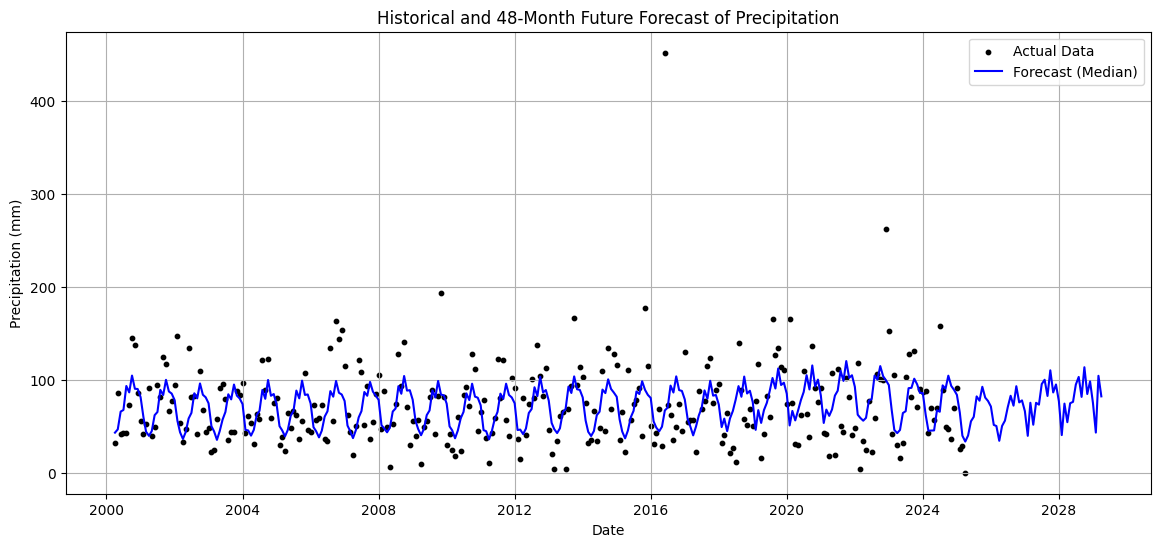

In [2]:
import warnings
warnings.filterwarnings('ignore')

if station not in df.columns:
    raise ValueError("Expected column station not found.")

df[station] = df[station].clip(lower=0)
df = df[[station]]
df = df.reset_index()
df['date'] = df['index'].dt.date
df = df.rename(columns={station: 'precipitation'})
df = df.drop(columns='index')
df = df.dropna(subset=['precipitation']).reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')
df_monthly = df.groupby('year_month')['precipitation'].sum().reset_index()
df_monthly['year_month'] = df_monthly['year_month'].dt.to_timestamp()
df_prophet = df_monthly.rename(columns={'year_month': 'ds', 'precipitation': 'y'})

# --- Quick data exploration ---
# plt.figure(figsize=(10, 5))
# plt.plot(df_prophet['ds'], df_prophet['y'], marker='o')
# plt.title('Monthly Precipitation Over Time')
# plt.xlabel('Date')
# plt.ylabel('Precipitation (mm)')
# plt.grid(True)
# plt.show()

# --- Train-test split for evaluation ---
split_idx = int(len(df_prophet) * 0.8)
df_train = df_prophet.iloc[:split_idx]
df_test = df_prophet.iloc[split_idx:]

# --- Initialize NeuralProphet model ---
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    #seasonality_mode='multiplicative',
    n_changepoints=20,
    changepoints_range=0.9,
    trend_reg=1,
    quantiles=[0.1, 0.9]
)

m = m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# --- Fit model on training set ---
metrics = m.fit(df_train, freq='M')

# --- Forecast on train + test periods ---
future = m.make_future_dataframe(df_train, periods=len(df_test), n_historic_predictions=True)
forecast = m.predict(future)

# # --- Plot forecast including quantiles ---
# plt.figure(figsize=(12, 6))
# plt.plot(forecast['ds'], forecast['yhat1'], label='Prediction (Median)', color='blue')
# if 'yhat1_lower' in forecast.columns and 'yhat1_upper' in forecast.columns:
#     plt.fill_between(forecast['ds'], forecast['yhat1_lower'], forecast['yhat1_upper'], color='blue', alpha=0.3, label='80% Prediction Interval')
# plt.scatter(df_prophet['ds'], df_prophet['y'], color='black', s=10, label='Actual Data')
# plt.title('Monthly Precipitation Forecast with Uncertainty Interval')
# plt.xlabel('Date')
# plt.ylabel('Precipitation (mm)')
# plt.legend()
# plt.grid(True)
# plt.show()

# --- Plot model components (trend, seasonality, etc.) ---
fig_components = m.plot_components(forecast)

# --- Plot model parameters ---
fig_parameters = m.plot_parameters()

# --- Evaluation on test set ---
forecast_test = forecast.iloc[-len(df_test):]
mae = mean_absolute_error(df_test['y'].values, forecast_test['yhat1'].values)
r2 = r2_score(df_test['y'].values, forecast_test['yhat1'].values)
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")

# # --- Plot actual vs predicted for test period ---
# plt.figure(figsize=(10, 5))
# plt.plot(df_test['ds'], df_test['y'], label='Actual', marker='o')
# plt.plot(df_test['ds'], forecast_test['yhat1'], label='Predicted', marker='x')
# if 'yhat1_lower' in forecast_test.columns and 'yhat1_upper' in forecast_test.columns:
#     plt.fill_between(df_test['ds'], forecast_test['yhat1_lower'], forecast_test['yhat1_upper'], color='blue', alpha=0.2, label='80% Interval')
# plt.title('Actual vs Predicted Precipitation (Test Set with Uncertainty)')
# plt.xlabel('Date')
# plt.ylabel('Precipitation (mm)')
# plt.legend()
# plt.grid(True)
# plt.show()

# --- Print final few metrics ---
print(metrics.tail())
# --- Forecast next 48 months into the future ---
future_48 = m.make_future_dataframe(df_prophet, periods=48, n_historic_predictions=True)  # <--- notice: True
forecast_48 = m.predict(future_48)
forecast_48['yhat1'] = forecast_48['yhat1'].clip(lower=0)
if 'yhat1_lower' in forecast_48.columns:
    forecast_48['yhat1_lower'] = forecast_48['yhat1_lower'].clip(lower=0)
    forecast_48['yhat1_upper'] = forecast_48['yhat1_upper'].clip(lower=0)


# --- Plot historical + forecasted precipitation together ---
plt.figure(figsize=(14, 6))

# Plot historical observed data
plt.scatter(df_prophet['ds'], df_prophet['y'], color='black', s=10, label='Actual Data')

# Plot fitted values (up to today)
plt.plot(forecast_48['ds'], forecast_48['yhat1'], label='Forecast (Median)', color='blue')

# Plot uncertainty if available
if 'yhat1_lower' in forecast_48.columns and 'yhat1_upper' in forecast_48.columns:
    plt.fill_between(forecast_48['ds'], forecast_48['yhat1_lower'], forecast_48['yhat1_upper'], color='blue', alpha=0.3, label='80% Prediction Interval')

plt.title('Historical and 48-Month Future Forecast of Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()



The limitations of this approach become immediately clear. While NeuralProphet provides a solid, smoothed forecast based on historical data, our objective requires a model that can respond to extreme precipitation events, such as those that could lead to flooding. NeuralProphet, and time series modelling in general, are not well suited to predict these outliers. These events are both rare and seemingly random, and time series models tend to optimize for overall accuracy, not the extremes.

 To make a time series forcasting model useful, we would essentially have to extend the model with a term, that would require the model to predict rare events. This would however, not be based on realistic predictions, unless external variables were added to this term. An option could be a multivariate model forecasting model, incorporating variables such as temperature, humidity, wind etc. However, the data collection process would increase the complexity and workload of our project considerably, and was therefore deemed unrealistic. 

As a result of this process, we switched methods, and opted to incorporate 'Survival Analysis', to predict the probability of rare events occuring in a given timeframe. This method is specifically designed to predict these rare events, and are possible to build using the percipiation data available to us.